## Trabajo Práctico: Red Neuronal Lineal.

aca hay que poner una introducción supongo idk



Nota: aca en el notebook usamos algunas funciones como @, qr, de NP solo para probar y comparar con
los resultados correctos (calculados con numpy). Las soluciones a todos los sistemas verdaderos y las implementaciones de 
todas las funciones nuestras implementan cada una de estas operaciones a mano. 

Lo que si, usamos las funciones np.sum, np.min, np.max para poder vectorizar cuentas que si no tardaban mucho, 
como prodint() que se usa en nuestra multiplicacion de matrices

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt

from alc import *
# TODO esto todo va a estar en alc cuando terminemos y hay que borrarlo
sys.path.append(".")
sys.path.append("./src")
sys.path.append("../src")
from labo00_auxiliares import *
from labo01_errores_igualdad import *
from labo02_TLs_basicas import *
from labo03_normas import *
from labo04_LU import *
from labo05_QR import *
from labo06_AVs import *
from labo07_markov import *
from labo08_SVD import *
import os


np.set_printoptions(precision=3, linewidth=150, suppress=True)

os.getcwd()[-3:]
tol = 0.01



no se explicar que hacemos las pruebas

Recordamos, los "t" son los valores de entrenamiento, y los v son los de testeo

In [2]:
Xt, Yt, Xv, Yv = cargarDataset("cats_and_dogs") 
#Xt, Yt, Xv, Yv =  cargarDatasetReducido("cats_and_dogs", 300, 900)
print(Xt.shape)
print(Xv.shape)
print(Yt[:,:3], Yt.shape)
print(Yt[:,:3], Yv.shape)

(1536, 2000)
(1536, 1000)
[[0 0 0]
 [1 1 1]] (2, 2000)
[[0 0 0]
 [1 1 1]] (2, 1000)


### QR
Tuvimos que cambiar la funcion de QR del labo para que acepte matrices no cuadradas.
  
Queremos no tener que volver a hacer cuentas muy largas mientras testeamos. QR por GS no es lento asi que no es tan necesario, pero lo hacemos empezando aca por consistencia

In [3]:
cache_save_enabled = True
cache_load_enabled = True

def cache(calc, name):
    if cache_load_enabled and os.path.isfile(f"{name}.npy"):
        return np.load(f"{name}.npy")
    else:
        val = calc()
        if cache_save_enabled:
            np.save(f"{name}.npy", val)
        return val

def cache_many(calc, names):
    if cache_load_enabled and all([os.path.isfile(f"{name}.npy") for name in names]):
        return tuple([cache(lambda:None, name) for name in names])
    else:
        vals = calc()
        for name, val in zip(names, vals):
            cache(lambda:val, name)
        return vals
    
# no quiero perder horas de computo pq fallo un assert, armo esto para que si "Fallaría" el assert te avisa
def pseudoAssertEquality(X,Y, atol = tol):
    try:
        assert np.allclose(X,Y, atol=tol)
    except:
        print("ERROR: Necesita tolerancia ", np.max(np.abs(X-Y)))
    

#### Por Gram shmidt

In [48]:
tiempogs = datetime.now()
Q, R = cache_many(lambda: QR_con_GS(traspuesta(Xt)), ["QGS", "RGS"])

WGS = cache(lambda:pinvGramSchmidt(Q,R,Yt), "WGS")

YvProbabilidadesGS = cache(lambda:matmul(WGS, Xv), "YvEsperadosGS")





In [49]:
tiempofinalgs = datetime.now()
print("Tardo:", (tiempofinalgs-tiempogs).seconds, "segundos")

Tardo: 1 segundos


In [50]:

# verificamos que 
pseudoAssertEquality(Q @ R, traspuesta(Xt), atol=tol) # lo hago con @ solo aca para probar

## comparemos con funcion numpy por si a caso
QNP,RNP = np.linalg.qr(traspuesta(Xt))
YvProbabilidadesNPQR = pinvGramSchmidt(QNP,RNP,Yt) @ Xv
pseudoAssertEquality(YvProbabilidadesGS,  YvProbabilidadesNPQR, atol=tol)
difProbabilidadesGR=np.max(np.abs(YvProbabilidadesGS-YvProbabilidadesNPQR))




<class 'numpy.ndarray'> <class 'numpy.ndarray'>
listo resolviendo sistema
listo trasponiendo
Calculando W


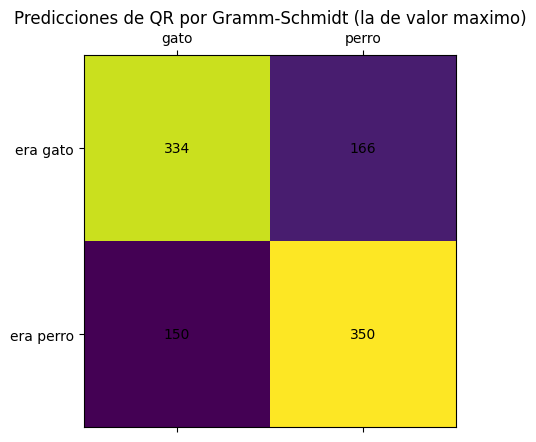

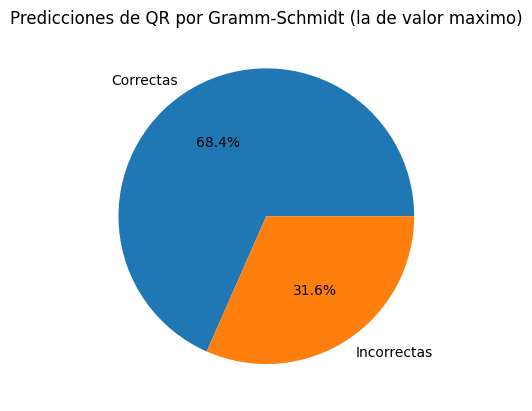

In [51]:
# medio feo tener un choclo de codigo aca pero peor era tener que importar matplotlib en ALC.py  
def graficar_predicciones_de_metodo(nombre_metodo, predicciones, valores_reales):
    gato = [1,0]
    perro = [0,1]


    posibilidadesNombres = ["gato", "perro"]
    confusion2 = np.zeros((2,2))
    for prediccion, valorCorrecto in zip(  traspuesta(predicciones) , traspuesta(valores_reales) ):
        indiceY = int(1-valorCorrecto[0])
        indiceX = int(max(prediccion) == prediccion[1])
        confusion2[ indiceY ][ indiceX ] += 1

    
    
    plt.matshow(confusion2)
    plt.title(f"Predicciones de {nombre_metodo} (la de valor maximo)")
    plt.xticks(range(len(posibilidadesNombres)), posibilidadesNombres)
    plt.yticks(range(len(posibilidadesNombres)), ["era "+n for n in posibilidadesNombres ])
    
    for i ,row in enumerate(confusion2):
        for j ,val in enumerate(row):
            plt.text(j, i, f"{int(val)}", ha="center", va="center", color="black") 
    plt.show()
    pie(confusion2, nombre_metodo + " (la de valor maximo)")

    return confusion2


def pie(confusion, nombre_metodo):
    correcto = 0
    incorrecto = 0
    for i in range(len(confusion)):
        correcto += confusion[i][i]

    incorrecto = len(Xv[0]) - correcto
    plt.pie([correcto, incorrecto], labels=["Correctas", "Incorrectas"], autopct='%1.1f%%')
    plt.title(f"Predicciones de {nombre_metodo}")
    plt.show()

confusionGS = graficar_predicciones_de_metodo("QR por Gramm-Schmidt", YvProbabilidadesGS, Yv)


como medida de performance se utilizó la exactitud, la cual se mide como $(TP + TN)/(P + N)$

In [52]:
exactitudGs = (confusionGS[0][0]+confusionGS[1][1])/(confusionGS[0][1]+confusionGS[1][0])

#### Por HH

In [53]:
tiempohh = datetime.now()

QHH, RHH = cache_many(lambda: QR_con_HH(traspuesta(Xt)), ["QHH", "RHH"])
WHH = cache(lambda:pinvHouseHolder(QHH,RHH,Yt), "WHH")
YvProbabilidadesHH = cache(lambda:matmul(WHH, Xv), "YvEsperadosHH")


pseudoAssertEquality(YvProbabilidadesHH,  YvProbabilidadesNPQR, atol=tol)
difProbabilidadesHH=np.max(np.abs(YvProbabilidadesHH-YvProbabilidadesNPQR))



In [54]:

tiempofinalhh = datetime.now()
print("Tardo:", (tiempofinalhh-tiempohh).seconds, "segundos")

Tardo: 0 segundos


In [55]:

# pseudoAssertEquality(WHH, WGS, atol=tol)

pseudoAssertEquality(QHH @ RHH, traspuesta(Xt), atol=tol) # lo hago con @ solo aca para probar mas rapido
print(f"W: {np.round(WHH,3).shape}")
print(YvProbabilidadesHH)
print(Yv)

W: (2, 1536)
[[-0.253  0.005 -0.255 ...  0.402  2.461  0.403]
 [ 1.027  0.345  1.371 ...  0.507 -0.557  0.306]]
[[0 0 0 ... 1 1 1]
 [1 1 1 ... 0 0 0]]


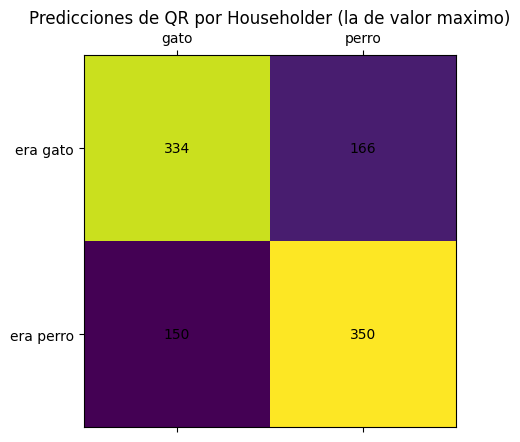

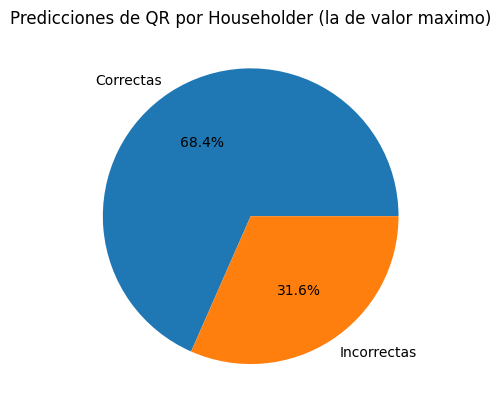

In [56]:
confusionHH = graficar_predicciones_de_metodo("QR por Householder", YvProbabilidadesHH, Yv)


In [57]:
exactitudHh = (confusionHH[0][0]+confusionHH[1][1])/(confusionHH[0][1]+confusionHH[1][0])

### SVD

In [61]:
tiemposvd = datetime.now()

U,S,V = cache_many(lambda: svd_reducida(Xt, tol=tol), ["U","S","V"])

# svd_reducida, como pide su enunciado, devuelve un vector en S. pero pinvSVD tiene que tomar una matriz. 
# generamos la matriz SM
def diagFrom(list, shape):
    res = np.zeros(shape)
    for i,item in  enumerate(list):
        res[i][i] = item
    return res

 

WSVD = cache(lambda:pinvSVD(U,diagFrom(S, Xt.shape),V,Yt), "WSVD")

YvProbabilidadesSVD = cache(lambda:matmul(WSVD, Xv), "YvEsperadosSVD")





In [62]:
tiempofinalsvd = datetime.now()
print("Tardo:", (tiempofinalsvd-tiemposvd).seconds, "segundos")

Tardo: 2 segundos


In [63]:


print(f"W: {np.round(WSVD,3).shape}")
pseudoAssertEquality(U @ np.diag(S) @ traspuesta(V), Xt, atol=tol)

print(YvProbabilidadesSVD)
print(Yv)

# Generamos un SVD usando numpy para comparar que tan diferente queda comparada con la nuestra 
UNP,SNP,VNP = np.linalg.svd(Xt)
VNP = VNP.T[:,:Xt.shape[0]]

WSVDNP = pinvSVD(UNP,diagFrom(SNP, Xt.shape),VNP,Yt)
YvProbabilidadesSVDNP = WSVDNP @ Xv

pseudoAssertEquality(YvProbabilidadesSVD, YvProbabilidadesSVDNP, atol=tol)

difProbabilidadesSVD=np.max(np.abs(YvProbabilidadesSVD-YvProbabilidadesSVDNP))


W: (2, 1536)
[[-0.292  0.015 -0.232 ...  0.389  2.368  0.492]
 [ 1.022  0.334  1.264 ...  0.5   -0.468  0.242]]
[[0 0 0 ... 1 1 1]
 [1 1 1 ... 0 0 0]]


KeyboardInterrupt: 

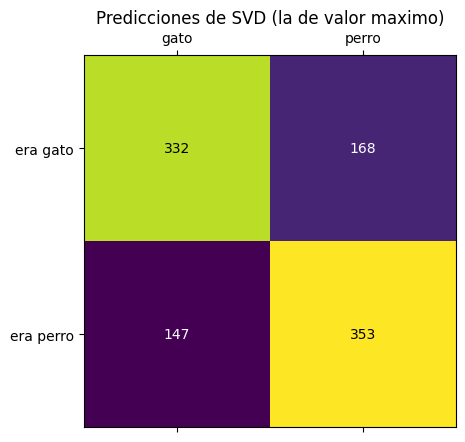

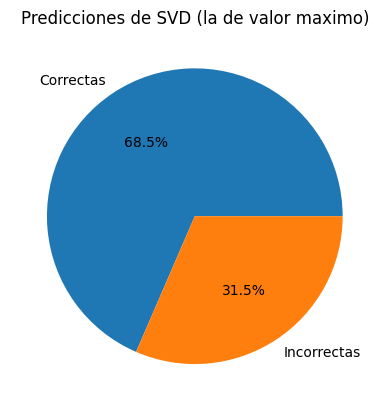

In [17]:
confusionSVD = graficar_predicciones_de_metodo("SVD", YvProbabilidadesSVD, Yv)

In [18]:
exactitudSvd = (confusionSVD[0][0]+confusionSVD[1][1])/(confusionSVD[0][1]+confusionSVD[1][0])

### Cholesky / Ecuaciones Normales

In [ ]:
tiempoeq= datetime.now()

LCholesky = cache(lambda: cholesky(matmul(Xt, traspuesta(Xt))), "LCholesky")

WEqNorm = cache(lambda:pinvEcuacionesNormales(Xt,LCholesky,Yt), "WEN")

YvProbabilidadesEqNorm = cache(lambda:matmul(WEqNorm, Xv), "YvEsperadosEqNorm")





Tardo: 0 segundos


In [ ]:
tiempofinaleq = datetime.now()
print("Tardo:", (tiempofinaleq-tiempoeq).seconds, "segundos")

In [20]:

print(f"W: {np.round(WEqNorm,3).shape}")
pseudoAssertEquality(LCholesky @ traspuesta(LCholesky), matmul(Xt, traspuesta(Xt)), atol=tol)

print(YvProbabilidadesEqNorm)
print(Yv)

# comparamos con el resultado de hacerlo con numpy
LCholeskyNP = np.linalg.cholesky(Xt @ Xt.T)

WWEqNormNP = pinvEcuacionesNormales(Xt, LCholeskyNP, Yt)
YvProbabilidadesEqNormNP = WWEqNormNP @ Xv

difProbabilidadesEqNorm=np.max(np.abs(YvProbabilidadesEqNorm-YvProbabilidadesEqNormNP))

W: (2, 1536)
[[-0.253  0.005 -0.255 ...  0.402  2.461  0.403]
 [ 1.027  0.345  1.371 ...  0.507 -0.557  0.306]]
[[0 0 0 ... 1 1 1]
 [1 1 1 ... 0 0 0]]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


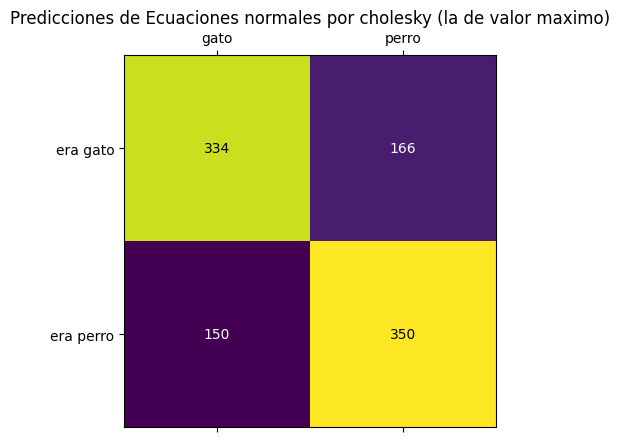

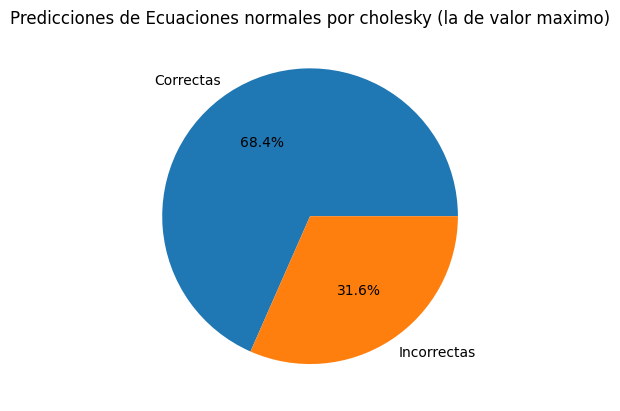

In [21]:
confusionEQ = graficar_predicciones_de_metodo("Ecuaciones normales por cholesky", YvProbabilidadesEqNorm, Yv)

In [22]:
exactitudEq = (confusionEQ[0][0]+confusionEQ[1][1])/(confusionEQ[0][1]+confusionEQ[1][0])

recordar que pinvecuacionesnormales tiene 3 for y uno vectorizado, pinvsvd tiene 4 y uno vectorizado (aunque hay uno que hace multiplicaciones cada vez mas chicas, seria 2.5), HH hace 5 for y uno vectorizado, y gr hace 2 y uno vectorizado.
capaz es mejor decir que hay algunos con muchas mas multiplicaciones de matrices.

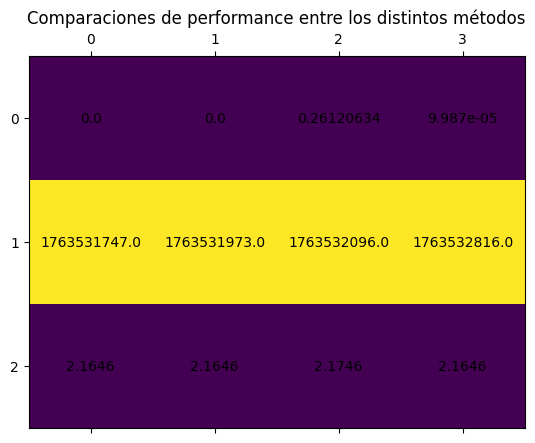

In [31]:
data=np.zeros((3,4))

# for i in data:
#     for j in data:
#         data[i][j]=

data[0][0]=difProbabilidadesGR
data[0][1]=difProbabilidadesHH
data[0][2]=difProbabilidadesSVD
data[0][3]=difProbabilidadesEqNorm
data[1][0]=round(tiempofinalgs.timestamp())
data[1][1]=round(tiempofinalhh.timestamp())
data[1][2]=round(tiempofinalsvd.timestamp())
data[1][3]=round(tiempofinaleq.timestamp())
data[2][0]=round(exactitudGs,4)
data[2][1]=round(exactitudHh,4)
data[2][2]=round(exactitudSvd,4)
data[2][3]=round(exactitudEq,4)


plt.matshow(data)
plt.title(f"Comparaciones de performance entre los distintos métodos")
# plt.xticks(range(3), posibilidadesNombres)
# plt.yticks(range(3), ["era "+n for n in posibilidadesNombres ])

for i ,row in enumerate(data):
    for j ,val in enumerate(row):
        plt.text(j, i, f"{round(val,8)}", ha="center", va="center", color="black") 

plt.show()

# table = tabulate(
#     data, 
#     headers=["GS", "HH", "SVD", "EQNORM"], 
#     tablefmt="grid"
# )

# print(table)

Todos los algoritmos utilizados para el cálculo de la pseudoinversa, se pudieron optimizar mediante vectorización, aprovechando los cálculos de la biblioteca numpy al hacer slicing, np.sum(), etc. Como se observa en la tabla comparativa de performance, Los tiempos de ejecución fueron bastante aceptables, sobre todo comparándolo con el tiempo que tardarían los métodos sin optimiarse que puede ser de horas o más de un día. Aún así, se pueden observar variaciones significativas en estos tiempos, ya que svd y householder fueron mayormente optimizados con vectorización. Cabe recalcar que si en lugar de nuestra función matmul, se utilizaba el @ de numpy, estos tiempos serían considerablemente menores. Teniendo en cuenta las complejidades teóricas de los algoritmos, NOSE SI ESO ESTA BIEN.
En esa misma tabla, se puede notar que las exactitudes son muy similares entre si, y de hecho al redondear los números, 3 de las 4 exactitudes son iguales.
También se tomó el máximo de las diferencias entre las probabilidades predichas por nuestro modelo y el modelo de numpy, en donde se ven variaciones más acentuadas.
A su vez, la precisión de los 4 métodos es cercana al 70%, lo cual parece ser no tan bueno, pero depende del uso que se le quiera dar.
Tambien, a medida que se va aumentando el, número de datos que se tienen en cuenta del dataset original, la precisión se va acercando al 70%. Esto se cumple para todos los métodos.
Si se observan las matrices de confusión de cada método, se puede concluir que el modelo predice más perros que gatos, por ende se tiene un mayor acierto de perros pero también un mayor error de perros. A su vez, pareciera que el modelo tiene más perros que gatos, y por eso el modelo adopta esa tendencia.
Si nos basamos tanto en precisión como en exactitud, SVD es el meétodo que mejor performance tiene (apenas notable la diferencia con el resto), mientras que los demás, al redondearse, quedan iguales.
Si nos basamos en tiempo de ejecución, el merjor método es
